In [2]:
import pandas as pd
import numpy as np
import json
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('../Cole.mplstyle')

from collections import defaultdict
from sklearn import svm
from sklearn import metrics
import lightgbm as lgb

/Users/scott/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Format keystroke df

In [3]:
all_users = np.arange(1,76)
all_sess = [0, 1, 2]
all_tasks = [0, 1]

N_char_trial = 100

df_trials_all = pd.read_csv('../processed_data/trial_keystrokes.csv', index_col=0)

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Compute normalized variance

In [4]:
df_vars = []

### dwell

In [5]:
# Determine dwell to use
dwell_use = []
with open('../processed_data/dwell_keys_use.txt', 'r') as filehandle:  
    for line in filehandle:
        dwell_use.append(line[:-1])

# Compute across-user variance: dwell
df_vara = df_trials_all.groupby(['user', 'key'])['dwell_time'].mean().reset_index()
across_user_std = df_vara.groupby('key')['dwell_time'].std().reset_index()
across_user_std = across_user_std[across_user_std['key'].isin(dwell_use)]
across_user_std.rename(columns={'dwell_time': 'std_across'}, inplace=True)

# Compute within-user variance
df_varw = df_trials_all.groupby(['user', 'key'])['dwell_time'].std().reset_index()
within_user_std = df_varw.groupby('key')['dwell_time'].mean().reset_index()
within_user_std = within_user_std[within_user_std['key'].isin(dwell_use)]
within_user_std.rename(columns={'dwell_time': 'std_within'}, inplace=True)

# Compute ratio
df_var = across_user_std.merge(within_user_std, on='key')
df_var['std_ratio'] = df_var['std_within'] / df_var['std_across']
df_var['key'] = ['dwell '+x for x in df_var['key']]
df_var.rename(columns={'key': 'feature'}, inplace=True)
df_vars.append(df_var)

### digraph

In [6]:
# Remove outliers and uncommon digraphs
with open('../processed_data/dg_cutoffs.pkl', 'rb') as f:
    dg_cutoffs = pickle.load(f)
    
# Remove digraphs not in the cutoff dict
df_dg_temp = df_trials_all[df_trials_all['key_pair'].isin(dg_cutoffs.keys())]

# Remove outlier keystrokes
def compute_too_long(key_pair, t):
    return t > dg_cutoffs[key_pair]

df_dg_temp['cutoff'] = df_dg_temp['key_pair'].map(dg_cutoffs)
df_dg_temp['too_long'] = df_dg_temp['cutoff'] < df_dg_temp['dg_time']
df_dg_temp = df_dg_temp[~df_dg_temp['too_long']]

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [7]:
# Compute across-user variance: dg
df_vara = df_dg_temp.groupby(['user', 'key_pair'])['dg_time'].mean().reset_index()
across_user_std = df_vara.groupby('key_pair')['dg_time'].std().reset_index()
across_user_std.rename(columns={'dg_time': 'std_across'}, inplace=True)

# Compute within-user variance
df_varw = df_dg_temp.groupby(['user', 'key_pair'])['dg_time'].std().reset_index()
within_user_std = df_varw.groupby('key_pair')['dg_time'].mean().reset_index()
within_user_std.rename(columns={'dg_time': 'std_within'}, inplace=True)

# Compute ratio
df_var = across_user_std.merge(within_user_std, on='key_pair')
df_var['std_ratio'] = df_var['std_within'] / df_var['std_across']
df_var['key_pair'] = ['digraph '+x for x in df_var['key_pair']]
df_var.rename(columns={'key_pair': 'feature'}, inplace=True)
df_vars.append(df_var)


### flight

In [8]:
# Compute across-user variance: flight
df_vara = df_dg_temp.groupby(['user', 'key_pair'])['flight_time'].mean().reset_index()
across_user_std = df_vara.groupby('key_pair')['flight_time'].std().reset_index()
across_user_std.rename(columns={'flight_time': 'std_across'}, inplace=True)

# Compute within-user variance
df_varw = df_dg_temp.groupby(['user', 'key_pair'])['flight_time'].std().reset_index()
within_user_std = df_varw.groupby('key_pair')['flight_time'].mean().reset_index()
within_user_std.rename(columns={'flight_time': 'std_within'}, inplace=True)

# Compute ratio
df_var = across_user_std.merge(within_user_std, on='key_pair')
df_var['std_ratio'] = df_var['std_within'] / df_var['std_across']
df_var['key_pair'] = ['flight '+x for x in df_var['key_pair']]
df_var.rename(columns={'key_pair': 'feature'}, inplace=True)
df_vars.append(df_var)


### trigraph

In [9]:
# Determine trigraph to use
trigraph_use = []
with open('../processed_data/trig_keys_use.txt', 'r') as filehandle:  
    for line in filehandle:
        trigraph_use.append(line[:-1])

# Compute across-user variance: trigraph
df_vara = df_trials_all.groupby(['user', 'key_trip'])['tg_time'].mean().reset_index()
across_user_std = df_vara.groupby('key_trip')['tg_time'].std().reset_index()
across_user_std = across_user_std[across_user_std['key_trip'].isin(trigraph_use)]
across_user_std.rename(columns={'tg_time': 'std_across'}, inplace=True)

# Compute within-user variance
df_varw = df_trials_all.groupby(['user', 'key_trip'])['tg_time'].std().reset_index()
within_user_std = df_varw.groupby('key_trip')['tg_time'].mean().reset_index()
within_user_std = within_user_std[within_user_std['key_trip'].isin(trigraph_use)]
within_user_std.rename(columns={'tg_time': 'std_within'}, inplace=True)

# Compute ratio
df_var = across_user_std.merge(within_user_std, on='key_trip')
df_var['std_ratio'] = df_var['std_within'] / df_var['std_across']
df_var['key_trip'] = ['trigraph '+x for x in df_var['key_trip']]
df_var.rename(columns={'key_trip': 'feature'}, inplace=True)
df_vars.append(df_var)
df_var = pd.concat(df_vars)

### Get normalized variance all feat

# Visualize

Text(0, 0.5, '')

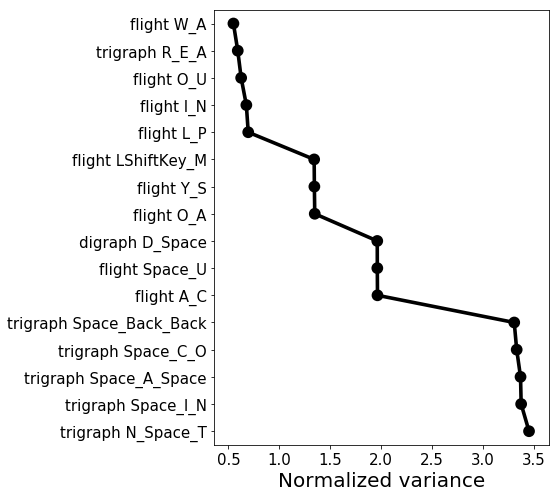

In [10]:
idx_plt = np.concatenate([np.arange(1,6), np.arange(205, 208), np.arange(604, 607), np.arange(830, 835)])
df_var_gb = df_var.groupby('feature')['std_ratio'].mean().sort_values()
pairs_keep = df_var_gb.index[idx_plt]
df_plt = df_var[df_var['feature'].isin(pairs_keep)]

plt.figure(figsize=(6, 8))
sns.pointplot(y='feature', x='std_ratio', data=df_plt, color='k',
              order=df_plt.groupby('feature')['std_ratio'].mean().sort_values().index)
plt.xlabel('Normalized variance')
plt.ylabel('')

### Normalized variance by feature type

In [11]:
df_vars[0]['feature type'] = 'dwell'
df_vars[1]['feature type'] = 'digraph'
df_vars[2]['feature type'] = 'flight'
df_vars[3]['feature type'] = 'trigraph'
df_var = pd.concat(df_vars)

/Users/scott/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Normalized variance')

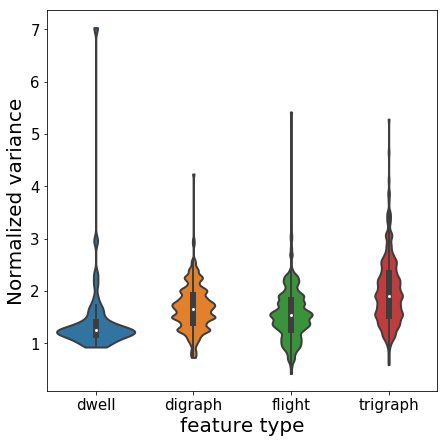

In [12]:
plt.figure(figsize=(7,7))
sns.violinplot(x='feature type', y='std_ratio', data=df_var,
               gridsize=1000, bw=.1, cut=0)
plt.ylabel('Normalized variance')